<img src='http://www-scf.usc.edu/~ghasemig/images/sharif.png' alt="SUT logo" width=200 height=200 align=left class="saturate" >

<br>
<font face="Times New Roman">
<div dir=ltr align=center>
<font color=0F5298 size=7>
    ML for Bioinformatics <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
<font color=3C99D size=5>
    Homework 3: Practical - Multi-Layer Perceptron (VAE) <br>
<font color=696880 size=4>
    Sobhan Moghimi (sobhanmoghimi45@gmail.com) <br>
    Fakhredin Abdi (fakhredinabdi80@gmail.com) <br>
    
____


### Full Name : Sajede Fadaei
### Student Number : 400211513

# Description

**In this assignment you'll be working with Dorothea Dataset.**

DOROTHEA is a drug discovery dataset. Chemical compounds represented by structural molecular features must be classified as active (binding to thrombin) or inactive.
To find out more about dataset, refer to this link: https://archive.ics.uci.edu/ml/datasets/Dorothea

You should implement a classifier with Neural Networks and for this purpose we will be using PyTorch as framework.

# Importing libraries, modules and Dataset.

In this part, import all the libraries and modules needed to solve the problem.

In [1]:
import os
import random 
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils import data
from torch.nn import functional as F
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from tqdm.notebook import tqdm

Now import the train and test data from dataset.

In [2]:
def to_matrix(filename, rows, cols):
    emp1_mat = np.zeros((rows, cols))
    with open(filename, 'r') as f:
        lines = f.readlines()
        for i, line in enumerate(lines):
            test_1 = np.array(line.strip().split()).astype("int")
            for j in test_1:
                emp1_mat[i, j-1] = 1
    return emp1_mat

X_train = to_matrix("dorothea_train.data", 800, 100_000)
X_test = to_matrix("dorothea_valid.data", 350, 100_000)
with open("dorothea_train.labels", 'r') as f:
    temp = f.readlines()
    Y_train = np.array([1 if x.strip() == '1' else 0 for x in temp])
with open("dorothea_valid.labels", 'r') as f:
    temp = f.readlines()
    Y_test = np.array([1 if x.strip() == '1' else 0 for x in temp])

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(800, 100000)
(350, 100000)
(800,)
(350,)


## Normalize
You can normalize your data using <code>Scikit-Learn</code> modules here.

In [3]:
X_train_norm = preprocessing.normalize(X_train, axis=0)
X_test_norm = preprocessing.normalize(X_test, axis=0)

## Dimensionality Reduction
There are too many attributes for each instance of dataset. We will suffer from sparse data and long training phase. Thus you can reduce dimensions to get better accuracy. 

Principal component analysis (PCA) is the process of computing the principal components and using them to perform a change of basis on the data.

Apply PCA on Dorothea dataSet using <code>Scikit-Learn</code>.

In [4]:
pca = PCA(n_components = 100)
X_train_pca = pca.fit_transform(X_train_norm)
X_test_pca = pca.fit_transform(X_test_norm)

# Define Model



In [5]:
# Define your model in here
# You can change the code below.

class ClassifierModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(100, 300)
        self.ac = nn.Tanh()
        self.l2 = nn.Linear(300, 1)
        
        self.loss = list()
    
    def forward(self, x):
        x = self.l1(x)
        x = self.ac(x)
        x = self.l2(x)
        
        return x
    
    def add_loss(self, loss):
        self.loss.append(loss)
        
    def clear_loss(self):
        self.loss = list()

# Train the model

**Initialize model, define hyperparameters, optimizer, loss function, etc.**



In [6]:
class Dorothea(data.Dataset):
    def __init__(self, size, data, labels):
        """
        Inputs:
            size - Number of data points we want to generate
            std - Standard deviation of the noise (see generate_continuous_xor function)
        """
        super().__init__()
        self.size = size
        self.data = data
        self.labels = labels

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        data_point = torch.cuda.FloatTensor(self.data[idx])
        data_label = torch.cuda.FloatTensor([self.labels[idx]])
        return data_point, data_label

In [7]:
def train_model(model, optimizer, data_loader, loss_module, num_epochs=100):
    model.train() 
    model.clear_loss()

    for epoch in tqdm(range(num_epochs)):
        for data_inputs, data_labels in data_loader:
            data_inputs = data_inputs.to(device)
            data_labels = data_labels.to(device)
            preds = model(data_inputs)            
            loss = loss_module(preds, data_labels.float())
            optimizer.zero_grad() 
            loss.backward()
            optimizer.step()
        model.add_loss(torch.Tensor.cpu(loss / len(data_loader.dataset)))

In [8]:
batch_size = 100
epochs = 150

model = ClassifierModel()
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

train_dataset = Dorothea(800, X_train_pca, Y_train)
test_dataset = Dorothea(350, X_test_pca, Y_test)

train_data_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_data_loader = data.DataLoader(test_dataset, batch_size=350, shuffle=True)

loss_module = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.002)

model.to(device)
train_model(model, optimizer, train_data_loader, loss_module, epochs)

  0%|          | 0/150 [00:00<?, ?it/s]

**After the training process, plot metrics such as loss function values.**

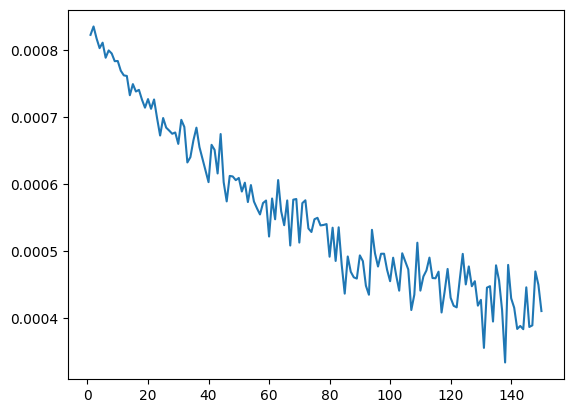

In [9]:
# Plot in here
loss_values = np.array([x.detach() for x in model.loss])
plt.plot(range(1, epochs+1), loss_values, label='Training Loss')
plt.show()

# Testing
After training, test your model on test dataset and compute performance metrics. 

In [10]:
# Implement Test in here
def eval_model(model, data_loader):
    model.eval() # Set model to eval mode
    true_preds, num_preds = 0, 0
    
    with torch.no_grad(): # Deactivate gradients for the following code
        for data_inputs, data_labels in data_loader:
            
            # Determine prediction of model on dev set
            data_inputs, data_labels = data_inputs.to(device), data_labels.to(device)
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1)
            preds = torch.sigmoid(preds) # Sigmoid to map predictions between 0 and 1
            pred_labels = (preds >= 0.5).long() # Binarize predictions to 0 and 1
            
            # Keep records of predictions for the accuracy metric (true_preds=TP+TN, num_preds=TP+TN+FP+FN)
            true_preds += (pred_labels == data_labels.squeeze(dim=1)).sum()
            num_preds += data_labels.shape[0]
            
    acc = true_preds / num_preds
    print(f"Accuracy of the model: {100*acc:4.2f}%")
    return torch.Tensor.cpu(pred_labels)
    
Y_pred = eval_model(model, test_data_loader)

Accuracy of the model: 89.14%


Show confusion matrix of your model.

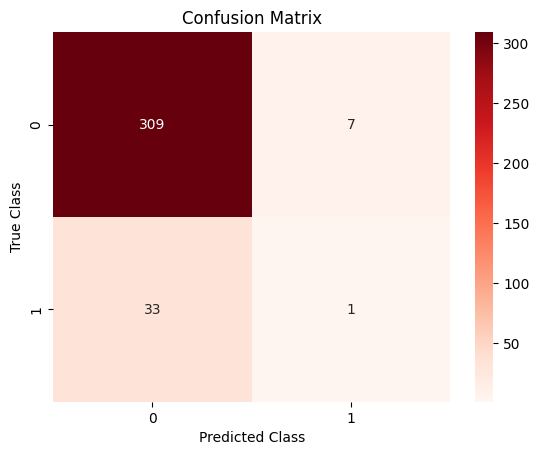

[[309   7]
 [ 33   1]]


In [11]:
# Print your confusion matrix here.
cm = confusion_matrix(Y_test, Y_pred)
labels = ['0', '1']
sns.heatmap(cm, annot=True, cmap='Reds', fmt='d', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

print(confusion_matrix(Y_test, Y_pred))